SVG文件已保存为 'power_curves.svg'


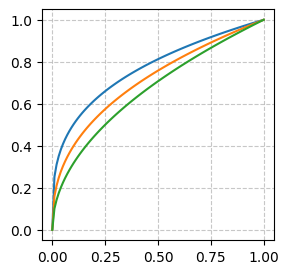

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 创建x值的数组
x = np.linspace(0, 1, 100)

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(3, 3))

# 绘制多条pow曲线
powers = [.3, .4, 0.5]
for power in powers:
    y = np.power(x, power)
    ax.plot(x, y, label=f'x^{power}')

# 添加图例
# ax.legend()

# 添加网格线
ax.grid(True, linestyle='--', alpha=0.7)

# 保存为SVG格式
plt.savefig('power_curves.svg', format='svg', dpi=300, bbox_inches='tight')

print("SVG文件已保存为 'power_curves.svg'")

In [1]:
import torch as pt

mols_test = pt.load('./data/mine/test_11499.pt')
print(len(mols_test))
mols_test_rep = pt.load('./data/mine/test_11499_rep.pt')
print(len(mols_test_rep))
mols_all = pt.load('./data/mine/mols_all_inchi.pt')
print(len(mols_all))
extra10 = pt.load('./data/mine/extra10.pt')
print(len(extra10))

/home/burger/miniconda3/envs/cu121/lib/python3.11/site-packages/pubchempy.py:563: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.charge is not 0:


11499
11499
2253216
10


In [2]:
mass_lib = [float(mol.metadata['nominal_mass']) for mol in mols_all]
mass_test = [float(mol.metadata['nominal_mass']) for mol in mols_test]
mass_10 = [float(mol.metadata['nominal_mass']) for mol in extra10]

In [3]:
from torch.utils.data import DataLoader
from utils.data import SpecDataset, collate_fun_emb

# dataset_test = SpecDataset(mols_test)
# loader_test = DataLoader(dataset_test, batch_size=2048, shuffle=False,
#                         num_workers=8, collate_fn=collate_fun_emb)
dataset_lib = SpecDataset(mols_all)
loader_lib = DataLoader(dataset_lib, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)
dataset_extra10 = SpecDataset(extra10)
loader_extra10 = DataLoader(dataset_extra10, batch_size=10, shuffle=False,
                            num_workers=1, collate_fn=collate_fun_emb)

In [4]:
from utils.model import Spec2Emb

gpu=6
model = Spec2Emb().to(gpu)
model.load_state_dict(pt.load('./model/mass_ft_p0.4_epoch2.pth', map_location='cpu'))

<All keys matched successfully>

In [5]:
from utils.tools import gen_embeddings, build_idx

embs_lib = gen_embeddings(model, loader_lib, gpu, power=0.4)
# embs_test = gen_embeddings(model, loader_test, gpu, power=0.4) 
embs_10 = gen_embeddings(model, loader_extra10, gpu, power=0.4)
# I, Dis = build_idx(embs_lib, embs_test, gpu)

In [6]:
from copy import deepcopy


embs_lib_mass = deepcopy(embs_lib)
# embs_test_mass = deepcopy(embs_test)
embs_10_mass = deepcopy(embs_10)
embs_lib_mass[:, -1] = mass_lib
# embs_test_mass[:, -1] = mass_test
embs_10_mass[:, -1] = mass_10

In [7]:
I_10, Dis_10 = build_idx(embs_lib_mass, embs_10_mass, gpu)
for i in range(len(I_10)):
    print('compound:'+str(i+1))
    for j in range(len(I_10[i])):
        if mols_all[I_10[i][j]].metadata['inchikey'] == extra10[i].metadata['inchikey']:
            print('Rank:', j+1)
            break

Searching time:  0:00:00.067859
compound:1
Rank: 1
compound:2
Rank: 1
compound:3
Rank: 1
compound:4
Rank: 1
compound:5
Rank: 1
compound:6
Rank: 2
compound:7
Rank: 12
compound:8
Rank: 9
compound:9
Rank: 35
compound:10
Rank: 27


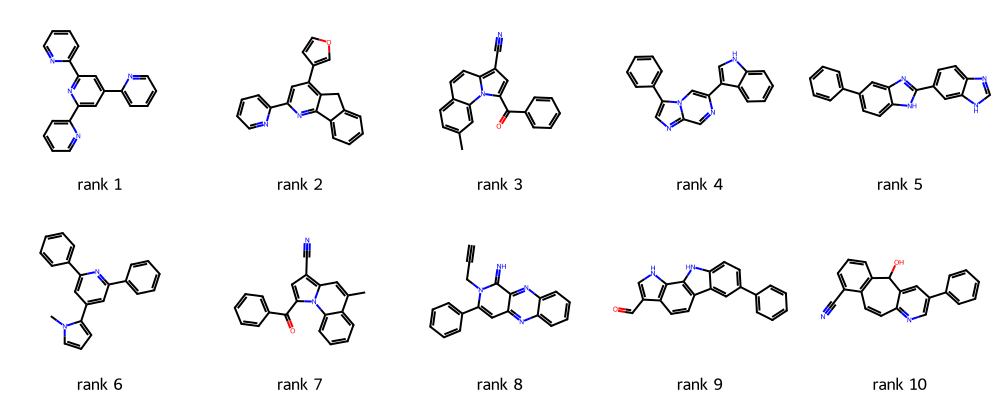

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw

candidate_mols9 = [mols_all[I_10[8][i]] for i in range(10)]
candidate_smi9 = [mol.metadata['smiles'] for mol in candidate_mols9]
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in candidate_smi9], molsPerRow=5, subImgSize=(200, 200), 
                     legends=[f'rank {i}' for i in range(1,11,1)], useSVG=True)

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from typing import Optional, Union
import numpy as np

_annotation_kws = {
    "horizontalalignment": "left",  # if not mirror_intensity else "right",
    "verticalalignment": "center",
    "fontsize": 7,
    "rotation": 90,
    "rotation_mode": "anchor",
    "zorder": 5,
}


def plot_spectrum(spectrum,
                  annotate_ions: bool = False,
                  mirror_intensity: bool = False,
                  grid: Union[bool, str] = True,
                  ax: plt.Axes = None,
                  peak_color="teal",
                  min_mz: float = None,
                  max_mz: float = None,
                  **plt_kwargs) -> plt.Axes:
    """
    Plot a single MS/MS spectrum.

    Code is largely taken from package "spectrum_utils".

    Parameters
    ----------
    spectrum: matchms.Spectrum
        The spectrum to be plotted.
    annotate_ions:
        Flag indicating whether or not to annotate fragment using peak comments
        (if present in the spectrum). The default is True.
    mirror_intensity:
        Flag indicating whether to flip the intensity axis or not.
    grid:
        Draw grid lines or not. Either a boolean to enable/disable both major
        and minor grid lines or 'major'/'minor' to enable major or minor grid
        lines respectively.
    ax:
        Axes instance on which to plot the spectrum. If None the current Axes
        instance is used.
    peak_color:
        Set color of peaks in plot.
    min_mz:
        Set lower limit of the plots x-axis to min_mz. Default is None.
    max_mz:
        Set upper limit of the plots x-axis to min_mz. Default is None.

    Returns
    -------
    plt.Axes
        The matplotlib Axes instance on which the spectrum is plotted.
    """
    # pylint: disable=too-many-locals, too-many-arguments
    if ax is None:
        ax = plt.gca()

    if min_mz is None:
        min_mz = max(0, np.floor(spectrum.peaks.mz[0] / 100 - 1) * 100)
    if max_mz is None:
        max_mz = np.ceil(spectrum.peaks.mz[-1] / 100 + 1) * 100
    max_intensity = spectrum.peaks.intensities.max()

    intensities = spectrum.peaks.intensities / max_intensity

    def make_stems():
        """calculate where the stems of the spectrum peaks are going to be"""
        x = np.zeros([2, spectrum.peaks.mz.size], dtype="float")
        y = np.zeros(x.shape)
        x[:, :] = np.tile(spectrum.peaks.mz, (2, 1))
        y[1, :] = intensities
        return x, y

    x, y = make_stems()
    if mirror_intensity is True:
        y = -y
    ax.plot(x, y, color=peak_color, linewidth=1.0, marker="", zorder=5, **plt_kwargs)
    if annotate_ions and isinstance(spectrum.get("peak_comments"), dict):
        for mz, comment in spectrum.get("peak_comments").items():
            idx = (-abs(spectrum.peaks.mz - mz)).argmax()
            ax.text(mz, intensities[idx], f"m/z: {mz} \n {comment}",
                    _annotation_kws)

    ax.set_xlim(min_mz, max_mz)
    # ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
    y_max = 1.25 if annotate_ions else 1.10
    ax.set_ylim(*(0, y_max) if not mirror_intensity else (-y_max, 0))
    y_ticks = ax.get_yticks()  
    ax.set_yticks(y_ticks[(y_ticks >= 0) & (y_ticks <= 1.0)])  # 确保y轴刻度在0到1之间

    ax.xaxis.set_minor_locator(mticker.AutoLocator())
    ax.yaxis.set_minor_locator(mticker.AutoLocator())
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
    if grid in (True, "both", "major"):
        ax.grid(visible=True, which="major", color="#9E9E9E", linewidth=0.2)
    if grid in (True, "both", "minor"):
        ax.grid(visible=True, which="minor", color="#9E9E9E", linewidth=0.2)
    ax.set_axisbelow(True)

    ax.tick_params(axis="both", which="both", labelsize="small")
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks[y_ticks <= 1.0])

    ax.set_xlabel("m/z", style="italic")
    ax.set_ylabel("Intensity")
    title = "Spectrum" if spectrum.get("compound_name") is None else spectrum.get("compound_name")
    # ax.set_title(title)
    return ax


def plot_spectra_mirror(spec_top,
                        spec_bottom,
                        ax: Optional[plt.Axes] = None,
                        color_top="darkblue",
                        color_bottom="teal",
                        **spectrum_kws) -> plt.Axes:
    """Mirror plot two MS/MS spectra.

    Code is largely taken from package "spectrum_utils".

    Parameters
    ----------
    spec_top: matchms.Spectrum.Spectrum.Spectrum
        The spectrum to be plotted on the top.
    spec_bottom: matchms.Spectrum.Spectrum.Spectrum
        The spectrum to be plotted on the bottom.
    ax:
        Axes instance on which to plot the spectrum. If None the current Axes
        instance is used.
    color_top:
        Set color of peaks in top spectrum.
    color_bottom:
        Set color of peaks in bottom spectrum.
    spectrum_kws:
        Keyword arguments for `plot_spectrum()`.

    Returns
    -------
    plt.Axes
        The matplotlib Axes instance on which the spectra are plotted.
    """
    if ax is None:
        ax = plt.gca()

    if spectrum_kws is None:
        spectrum_kws = {}

    if 'peak_color' in spectrum_kws:
        raise ValueError("'peak_color' should not be set for `plot_spectra_mirror`. "
                         "Use 'color_top' and 'color_bottom' instead.")

    # Top spectrum.
    plot_spectrum(spec_top, mirror_intensity=False, ax=ax, peak_color=color_top, **spectrum_kws)
    y_max = ax.get_ylim()[1]

    # Mirrored bottom spectrum.
    plot_spectrum(spec_bottom, mirror_intensity=True, ax=ax, peak_color=color_bottom, **spectrum_kws)
    y_min = ax.get_ylim()[0]
    ax.set_ylim(y_min, y_max)

    ax.axhline(0, color="#9E9E9E", zorder=10)

    # Update axes so that both spectra fit.
    min_mz = max(
        [
            0,
            np.floor(spec_top.peaks.mz[0] / 100 - 1) * 100,
            np.floor(spec_bottom.peaks.mz[0] / 100 - 1) * 100,
        ]
    )
    max_mz = max(
        [
            np.ceil(spec_top.peaks.mz[-1] / 100 + 1) * 100,
            np.ceil(spec_bottom.peaks.mz[-1] / 100 + 1) * 100,
        ]
    )

    # # Enforce min_mz and max_mz if provided
    max_mz = spectrum_kws.get("max_mz", max_mz)
    min_mz = spectrum_kws.get("min_mz", min_mz)

    ax.set_xlim(min_mz, max_mz)
    ax.yaxis.set_major_locator(mticker.AutoLocator())
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: f"{abs(x)}")
    )

    name1 = "Spectrum 1" if spec_top.get("compound_name") is None else spec_top.get("compound_name")
    name2 = "Spectrum 2" if spec_bottom.get("compound_name") is None else spec_bottom.get("compound_name")

    x_text = 0.04 * (max_mz - min_mz) + min_mz
    # ax.text(x_text, y_max, name1, ha="left", va="top", zorder=2, backgroundcolor="white")
    # ax.text(x_text, y_min, name2, ha="left", va="bottom", zorder=2, backgroundcolor="white")
    return ax

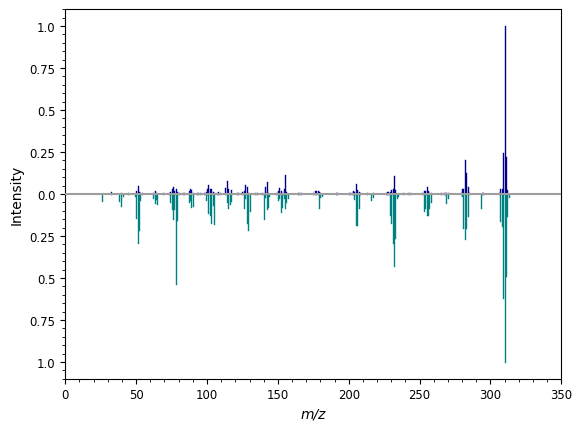

In [33]:
fig = plt.figure()
ax = fig.add_subplot()
ax = plot_spectra_mirror(extra10[8], candidate_mols9[0],ax=ax,  grid=False, max_mz=350.0)
fig.savefig('./picture/spec comp.svg', format='svg', dpi=500)